In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import PIL as Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import os
from glob import glob
from tqdm.auto import tqdm
import imgaug

In [2]:
# download dataset
!pip install --upgrade gdown
!gdown --id 1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H --output brain-mri-seg.zip
# unzip file
!unzip -q brain-mri-seg.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H
From (redirected): https://drive.google.com/uc?id=1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H&confirm=t&uuid=2b80912d-453e-4f81-a3ac-a380b7f35468
To: /content/brain-mri-seg.zip
100% 130M/130M [00:02<00:00, 47.4MB/s]


In [3]:
mask_path = glob("/content/brain-mri-seg/train/*_mask.tif")
img_path = [path.replace("_mask", "") for path in mask_path]

In [4]:
index = np.random.randint(0, len(img_path))
mask = cv2.imread(mask_path[index])
img = cv2.imread(img_path[index])

print(img.shape)
print(mask.shape)

(256, 256, 3)
(256, 256, 3)


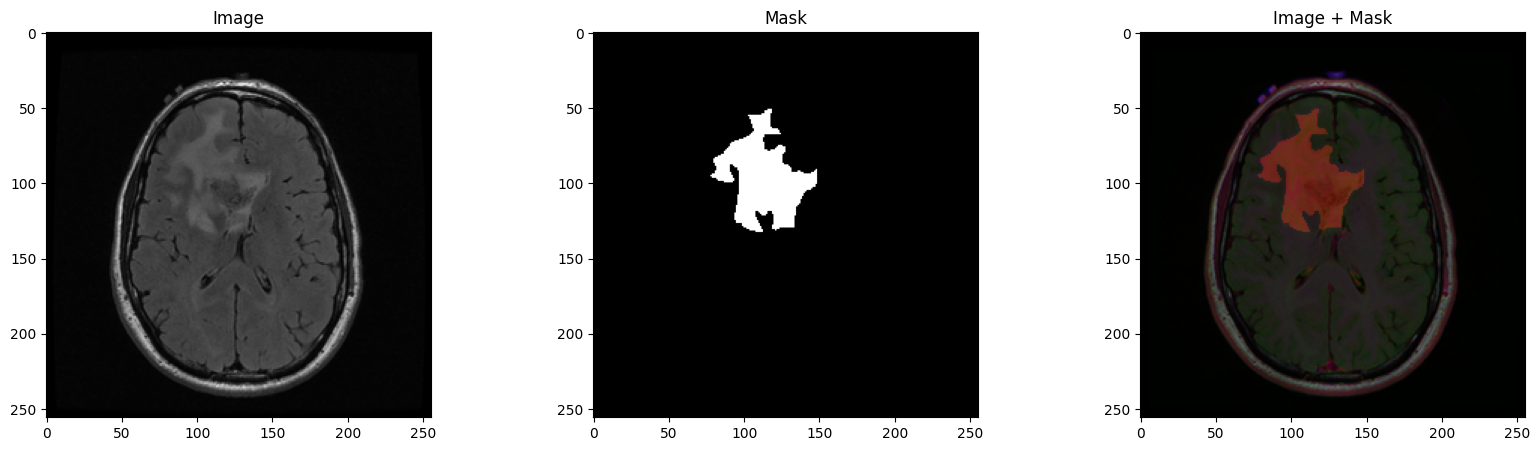

In [5]:
# show image & mask
def plot_img_mask(img, mask):
    plt.figure(figsize=(20, 5))
    plt.subplot(1,3,1)
    plt.title('Image')
    plt.imshow(img[:, :, 1], cmap = "gray")
    plt.subplot(1,3,2)
    plt.title('Mask')
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.title('Image + Mask')
    plt.imshow(img)
    plt.imshow(mask * np.array([1, 0, 0]), alpha=0.3) # convert mask to red color
    plt.show()

plot_img_mask(img, mask)

In [6]:
img_size = 256
bs = 16

In [7]:
class TumorDataset(torch.utils.data.Dataset):
  def __init__(self, folder_path, img_size, augmentation = False):
    self.mask_paths = glob(os.path.join(folder_path, '*_mask.tif'))
    self.img_paths = [m_path.replace('_mask', '') for m_path in self.mask_paths]
    self.img_size = img_size

    self.augmentation = augmentation
    self.augmenter = imgaug.augmenters.Sequential([
        imgaug.augmenters.Fliplr(0.5),
        imgaug.augmenters.Affine(
                rotate=(-45, 45), # random rotate -45 ~ +45 degree
                shear=(-16, 16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            )
    ])

  def __len__(self):
    return len(self.mask_paths)

  def __getitem__(self, idx):
    #get image and mask:
    mask = cv2.imread(self.mask_paths[idx]) #black&white (H,W,3) -> single channel -> gray
    img = cv2.imread(self.img_paths[idx]) #3 modalities (H,W,3) -> pick second -> gray
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    mask = cv2.resize(mask, (img_size, img_size))

    mask = mask[:, :, :1]
    img = img/255.
    mask = np.where(mask<127, 0, 1).astype(np.int16)

    if self.augmentation:
      # to imgaug data class
      mask = imgaug.augmentables.segmaps.SegmentationMapsOnImage(mask,shape=mask.shape)
      # augment img & mask "simultaneously"
      img, mask = self.augmenter(image=img, segmentation_maps=mask)
      mask = mask.get_arr() # to np.ndarray

    img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
    mask = torch.tensor(mask, dtype=torch.long).squeeze(-1) # (H, W, 1) -> (H, W)
    return img, mask




In [8]:
train_ds = TumorDataset('brain-mri-seg/train',
                        img_size,
                        augmentation=True)
val_ds = TumorDataset('brain-mri-seg/test',
                      img_size)

# https://pytorch.org/docs/stable/data.html
# >0: accelerate loading data by muli-process
NUM_WORKERS = 2

train_loader = torch.utils.data.DataLoader(train_ds,
                                           bs,
                                           shuffle=True,
                                           num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_ds,
                                         bs,
                                         num_workers=NUM_WORKERS)

print(len(val_ds))
print(len(train_ds))

275
1098


img.shape:  torch.Size([3, 256, 256]) 
mask.shape:  torch.Size([256, 256])
mask values:  [0 1]


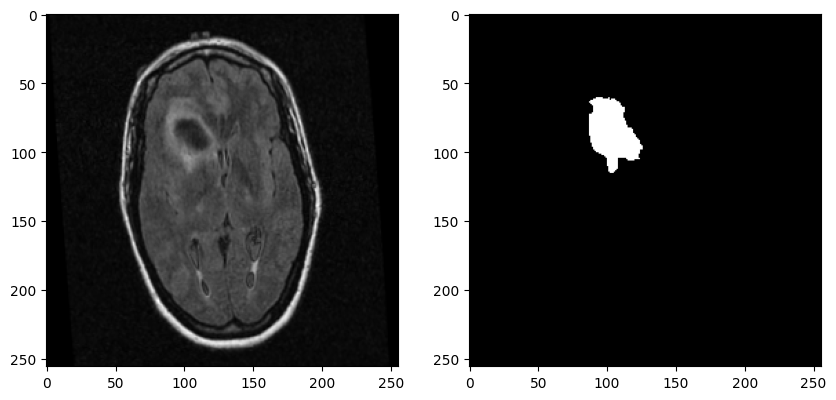

In [9]:
img, mask = train_ds[42] # take 1 data

print('img.shape: ', img.shape, '\nmask.shape: ', mask.shape)
print('mask values: ', np.unique(mask))
img = img.numpy().transpose(1, 2, 0) # (C, H, W) -> (H, W, C)
mask = mask.numpy().squeeze() # (1, H, W) -> (H, W)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:,:,1], cmap = "gray")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

In [10]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self, in_channels = 3, out_channels = 2, init_features = 32):
    super().__init__()
    #Encoder Architecture:
    self.encoder1 = ConvBlock(in_channels, init_features) # (3, H, W) -> (32, H, W)
    self.pool1 = nn.MaxPool2d(2)
    self.encoder2 = ConvBlock(init_features, init_features*2) # (32, H/2, W/2) -> (64, H/2, W/2)
    self.pool2 = nn.MaxPool2d(2)
    self.encoder3 = ConvBlock(init_features*2, init_features*4) # (64, H/4, W/4) -> (128, H/4, W/4)
    self.pool3 = nn.MaxPool2d(2)
    self.encoder4 = ConvBlock(init_features*4, init_features*8) # (128, H/8, W/8) -> (256, H/8, W/8)
    self.pool4 = nn.MaxPool2d(2)
    self.encoder5 = ConvBlock(init_features*8, init_features*16) # (256, H/16, W/16) -> (512, H/16, W/16)

    #Decoder Architecture:
    self.upconv4 = nn.ConvTranspose2d(init_features*16, init_features*8, kernel_size = 2, stride = 2)
    self.decoder4 = ConvBlock(init_features*8*2, init_features*8)
    self.upconv3 = nn.ConvTranspose2d(init_features*8, # (256, H/8, W/8) -> (128, H/4, W/4)
                          init_features*4,
                          kernel_size=2, stride=2)
    self.decoder3 = ConvBlock(init_features*4*2, init_features*4)
    self.upconv2 = nn.ConvTranspose2d(init_features*4, # (128, H/4, W/4) -> (64, H/2, W/2)
                          init_features*2,
                          kernel_size=2, stride=2)
    self.decoder2 = ConvBlock(init_features*2*2, init_features*2)
    self.upconv1 = nn.ConvTranspose2d(init_features*2, # (62, H/2, W/2) -> (32, H, W)
                          init_features,
                          kernel_size=2, stride=2)
    self.decoder1 = ConvBlock(init_features*2, init_features)

    #output head:
    self.output = nn.Conv2d(init_features, out_channels = out_channels, kernel_size = 1)

  def forward(self, x):
        # Encoder
      enc1 = self.encoder1(x)
      enc2 = self.encoder2(self.pool1(enc1))
      enc3 = self.encoder3(self.pool2(enc2))
      enc4 = self.encoder4(self.pool3(enc3))
      bottleneck = self.encoder5(self.pool4(enc4))

        # Decoder
        # (BS, 256, H/8, W/8) + (BS, 256, H/8, W/8) -> (BS, 512, H/8, W/8)
      x = torch.cat((self.upconv4(bottleneck), enc4), dim=1)
      x = self.decoder4(x)

      x = torch.cat((self.upconv3(x), enc3), dim=1)
      x = self.decoder3(x)

      x = torch.cat((self.upconv2(x), enc2), dim=1)
      x = self.decoder2(x)

      x = torch.cat((self.upconv1(x), enc1), dim=1)
      x = self.decoder1(x)

      x = self.output(x)
      return x




In [11]:
inputs = torch.randn(1, 3, 256, 256)
model = UNet(in_channels=3,
             out_channels=2,
             init_features=16)
outputs = model(inputs)
outputs.shape

torch.Size([1, 2, 256, 256])

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# build model to GPU
model = UNet(in_channels=3,
             out_channels=2,
             init_features=16).to(device)

cuda


In [13]:
# PyTorch Dice loss
!pip install fusionlab

import fusionlab as fl
from fusionlab.losses import DiceLoss, IoULoss

class DiceScore(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice_loss = DiceLoss()
    def forward(self, pred, true):
        loss = self.dice_loss(pred, true)
        return 1-loss

dice_score = DiceScore()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 21.1 MB/s eta 0:00:00
PyTorch installed: True
TensorFlow installed: True


In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_dice = 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item() # tensor -> python value
        epoch_dice += dice_score(pred, y).item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_dice/num_batches


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_dice = 0
    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_dice += dice_score(pred, y).item()

    return epoch_loss/num_batches, epoch_dice/num_batches

In [15]:
EPOCHS = 50
logs = {
    'train_loss': [], 'val_loss': [],
    'train_dice': [], 'val_dice': [],
}
# loss_fn = nn.CrossEntropyLoss() # classification for each pixel
loss_fn = fl.losses.DiceLoss("multiclass") # IoULoss

optimizer = torch.optim.Adam(model.parameters())

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_dice = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_dice = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_dice'].append(train_dice)
    logs['val_dice'].append(val_dice)

    print(f'EPOCH: {epoch:04d} train_loss: {train_loss:.4f} val_loss: {val_loss:.4f}, train_dice: {train_dice:.3f}, val_dice: {val_dice:.3f}')

    # On epoch end
    torch.save(model.state_dict(), "last.pth")
    # check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0000 train_loss: 0.5488 val_loss: 0.5006, train_dice: 0.451, val_dice: 0.499


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0001 train_loss: 0.4464 val_loss: 0.4215, train_dice: 0.554, val_dice: 0.578


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0002 train_loss: 0.3394 val_loss: 0.2771, train_dice: 0.661, val_dice: 0.723


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0003 train_loss: 0.2322 val_loss: 0.2897, train_dice: 0.768, val_dice: 0.710


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0004 train_loss: 0.1762 val_loss: 0.2073, train_dice: 0.824, val_dice: 0.793


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0005 train_loss: 0.1476 val_loss: 0.1715, train_dice: 0.852, val_dice: 0.828


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0006 train_loss: 0.1300 val_loss: 0.1767, train_dice: 0.870, val_dice: 0.823


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0007 train_loss: 0.1224 val_loss: 0.1429, train_dice: 0.878, val_dice: 0.857


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0008 train_loss: 0.1150 val_loss: 0.1530, train_dice: 0.885, val_dice: 0.847


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0009 train_loss: 0.1077 val_loss: 0.1200, train_dice: 0.892, val_dice: 0.880


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0010 train_loss: 0.1115 val_loss: 0.1161, train_dice: 0.889, val_dice: 0.884


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0011 train_loss: 0.1022 val_loss: 0.1115, train_dice: 0.898, val_dice: 0.888


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0012 train_loss: 0.0969 val_loss: 0.1023, train_dice: 0.903, val_dice: 0.898


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0013 train_loss: 0.0949 val_loss: 0.1366, train_dice: 0.905, val_dice: 0.863


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0014 train_loss: 0.1013 val_loss: 0.1008, train_dice: 0.899, val_dice: 0.899


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0015 train_loss: 0.0920 val_loss: 0.0924, train_dice: 0.908, val_dice: 0.908


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0016 train_loss: 0.0979 val_loss: 0.0992, train_dice: 0.902, val_dice: 0.901


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0017 train_loss: 0.0933 val_loss: 0.1427, train_dice: 0.907, val_dice: 0.857


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0018 train_loss: 0.0878 val_loss: 0.0962, train_dice: 0.912, val_dice: 0.904


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0019 train_loss: 0.0898 val_loss: 0.0831, train_dice: 0.910, val_dice: 0.917


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0020 train_loss: 0.0782 val_loss: 0.0778, train_dice: 0.922, val_dice: 0.922


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0021 train_loss: 0.0861 val_loss: 0.0827, train_dice: 0.914, val_dice: 0.917


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0022 train_loss: 0.0801 val_loss: 0.0802, train_dice: 0.920, val_dice: 0.920


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0023 train_loss: 0.0825 val_loss: 0.0697, train_dice: 0.917, val_dice: 0.930


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0024 train_loss: 0.0786 val_loss: 0.0719, train_dice: 0.921, val_dice: 0.928


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0025 train_loss: 0.0765 val_loss: 0.0739, train_dice: 0.924, val_dice: 0.926


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0026 train_loss: 0.0763 val_loss: 0.0721, train_dice: 0.924, val_dice: 0.928


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0027 train_loss: 0.0769 val_loss: 0.0693, train_dice: 0.923, val_dice: 0.931


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0028 train_loss: 0.0739 val_loss: 0.0672, train_dice: 0.926, val_dice: 0.933


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0029 train_loss: 0.0746 val_loss: 0.0757, train_dice: 0.925, val_dice: 0.924


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0030 train_loss: 0.0745 val_loss: 0.0652, train_dice: 0.925, val_dice: 0.935


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0031 train_loss: 0.0718 val_loss: 0.0704, train_dice: 0.928, val_dice: 0.930


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0032 train_loss: 0.0753 val_loss: 0.0673, train_dice: 0.925, val_dice: 0.933


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0033 train_loss: 0.0775 val_loss: 0.0721, train_dice: 0.923, val_dice: 0.928


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0034 train_loss: 0.0757 val_loss: 0.0705, train_dice: 0.924, val_dice: 0.930


  0%|          | 0/69 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2beb7e24d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2beb7e24d0>  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

EPOCH: 0035 train_loss: 0.0737 val_loss: 0.0635, train_dice: 0.926, val_dice: 0.937


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0036 train_loss: 0.0715 val_loss: 0.0703, train_dice: 0.929, val_dice: 0.930


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0037 train_loss: 0.0694 val_loss: 0.0686, train_dice: 0.931, val_dice: 0.931


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0038 train_loss: 0.0734 val_loss: 0.0682, train_dice: 0.927, val_dice: 0.932


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0039 train_loss: 0.0698 val_loss: 0.0628, train_dice: 0.930, val_dice: 0.937


  0%|          | 0/69 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2beb7e24d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2beb7e24d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

EPOCH: 0040 train_loss: 0.0722 val_loss: 0.0727, train_dice: 0.928, val_dice: 0.927


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0041 train_loss: 0.0693 val_loss: 0.0641, train_dice: 0.931, val_dice: 0.936


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0042 train_loss: 0.0682 val_loss: 0.0642, train_dice: 0.932, val_dice: 0.936


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0043 train_loss: 0.0665 val_loss: 0.0697, train_dice: 0.933, val_dice: 0.930


  0%|          | 0/69 [00:00<?, ?it/s]

EPOCH: 0044 train_loss: 0.0728 val_loss: 0.0660, train_dice: 0.927, val_dice: 0.934
Earlystop!


In [ ]:
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.title('loss')
plt.show()
plt.plot(logs['train_dice'])
plt.plot(logs['val_dice'])
plt.title('Dice')
plt.show()

In [ ]:
model.load_state_dict(torch.load("best.pth"))

In [ ]:
# Sample data
idx = np.random.randint(len(val_ds))
print(idx)
img, mask = val_ds[idx] # (3, H, W) (H, W)
mask_pred = model(img.unsqueeze(0).to(device))

# show inputs img, GT, model prediction
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('GT')
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.title("Pred")
plt.imshow(mask_pred[0].cpu().argmax(0))
plt.show()